In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd 
from selenium import webdriver
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
# import tensorflow as tf
# import tensorflow_probability as tfp
import numpy as np

In [3]:

s = int(datetime.today().timestamp())

url = f'https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2={s}&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true'

driver = webdriver.Chrome() 

driver.get(url)
driver.implicitly_wait(10)

for _ in range(400):
    driver.execute_script("window.scrollBy(0, 500);")

content = driver.page_source

driver.quit()



In [4]:
soup = BeautifulSoup(content, 'html.parser')


table = soup.find('table', {'data-test': 'historical-prices'})

df = pd.read_html(str(table))[0]
df = df.drop(df.index[-1])



print(df.shape)

C:\Users\teani\AppData\Local\Temp\ipykernel_18044\2200980255.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


(3427, 7)


In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')
df['Date'] = pd.to_datetime(df['Date'], "%b %d, %Y")
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df['Close*'] = df['Close*'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float)

df['Close'] = df['Close*'].astype(float)

df = df.drop(columns = ['Adj Close**', 'Close*'])
df = df.head(3400)



In [6]:
# df.to_csv('btcJAN30.csv', index = False)

In [7]:
# df = pd.read_csv('btcJAN30.csv').head(200)

<Axes: xlabel='Date'>

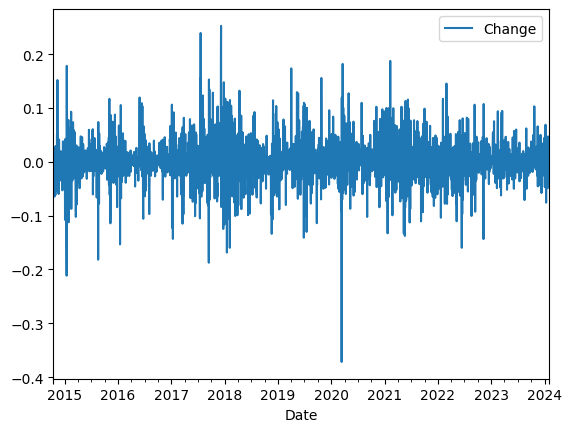

In [8]:
df["Change"] = df["Close"].pct_change(periods=-1)  #procentualna promena 
df.drop(df.tail(1).index,inplace=True)

df.plot(x = 'Date',y = 'Change')


<Axes: xlabel='Date'>

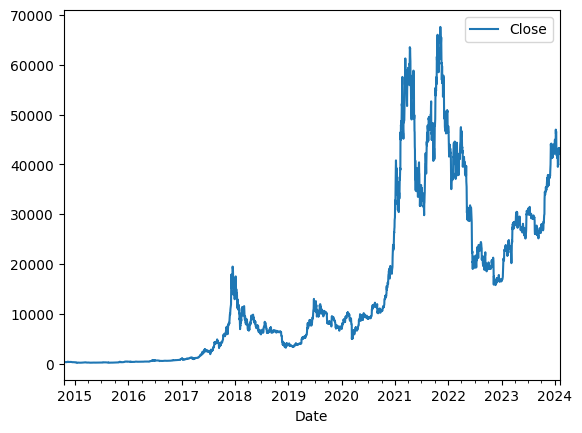

In [9]:
df.plot(x = 'Date', y = 'Close')

In [10]:
train_len = int(0.8 * len(df))
test_len = len(df) - train_len

train = (df.tail(train_len)).copy()
test = (df.head(test_len)).copy()

train = train.sort_values("Date").reset_index()
test = test.sort_values("Date").reset_index()

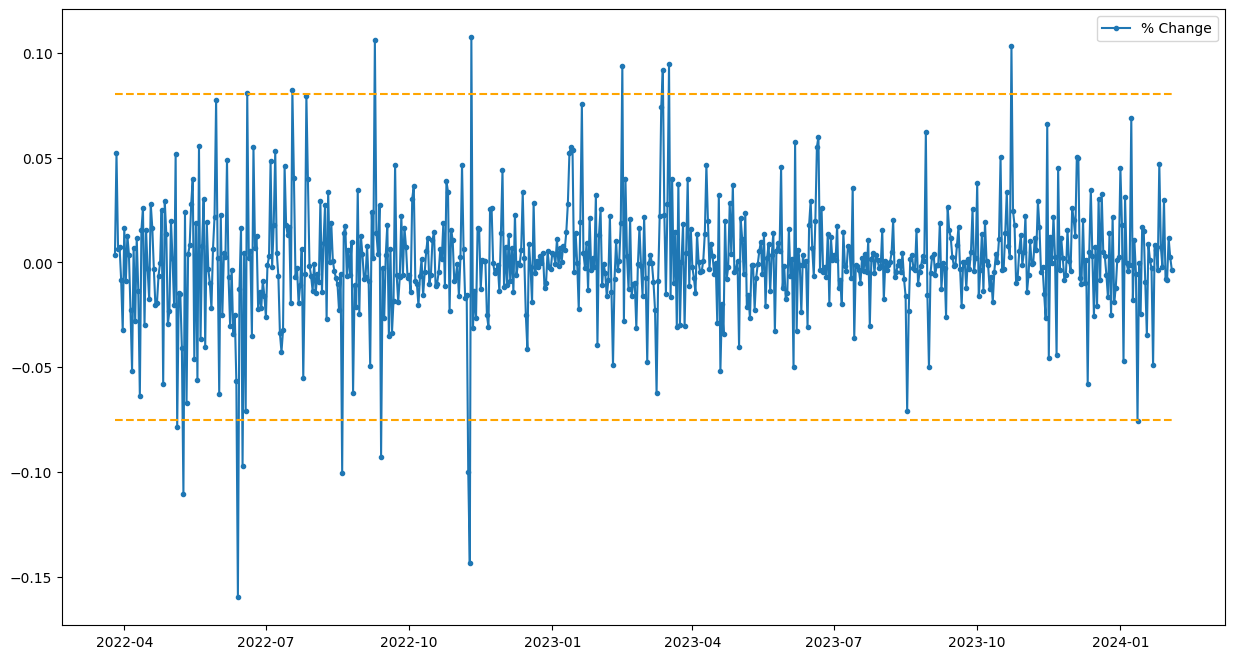

In [11]:
mean = train["Change"].mean()
std = train["Change"].std()

test["Upper"] = mean + 2*std
test["Lower"] = mean - 2*std

plt.figure(figsize=(15, 8))

plt.plot(test["Date"], test["Change"], label="% Change", marker=".")
plt.plot(test["Date"], test["Upper"], linestyle="--", color="orange")
plt.plot(test["Date"], test["Lower"], linestyle="--", color="orange")
plt.legend()


In [12]:
auto_arima = pm.auto_arima(train["Change"], trace=True, stepwise=False, seasonal=False)
auto_arima.summary()

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-9936.000, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-9934.944, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-9932.977, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-9931.715, Time=0.25 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-9930.418, Time=0.11 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=-9928.961, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-9934.950, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-9932.954, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-9941.820, Time=0.62 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-9929.647, Time=0.30 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-9928.421, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-9932.971, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-9930.973, Time=0.36 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-9928.975, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-9927.653, Time=0.37

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2719
Model:               SARIMAX(1, 0, 2)   Log Likelihood                4974.910
Date:                Sat, 03 Feb 2024   AIC                          -9941.820
Time:                        09:40:51   BIC                          -9918.188
Sample:                             0   HQIC                         -9933.277
                               - 2719                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9943      0.004    233.593      0.000       0.986       1.003
ma.L1         -1.0172      0.013    -81.031      0.000      -1.042      -0.993
ma.L2          0.0292      0.013      2.273      0.023       0.004       0.054
sigma2         0.0015   1.92e-05     78.625      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6025.79
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
best_order = auto_arima.get_params().get("order")
type(best_order)

tuple

In [14]:
history = [x for x in train["Change"]]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=best_order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test["Change"][t]
    history.append(obs)


c:\Users\teani\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\teani\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\teani\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\teani\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [15]:
print("Predicted BTC Price Change for Tomorrow:", predictions[-1])
len(predictions)

Predicted BTC Price Change for Tomorrow: 0.0022356973653845464


680

In [26]:
#RMSE - Uzimanje u obzir ovih aspekata pomaže u celokupnoj proceni performansi vašeg 
# sistema za predviđanje cena Bitcoin-a i obaveštenja. Važno je pratiti 
# ne samo tačnost prognoza već i kako vaš sistem doprinosi donošenju informisanih odluka 
# u realnom vremenu.

y_true = test["Change"]
y_pred = predictions

squared_diff = (y_true - y_pred) ** 2

mean_squared_diff = np.mean(squared_diff)

rmse = np.sqrt(mean_squared_diff)

rmse


0.03436610066976456

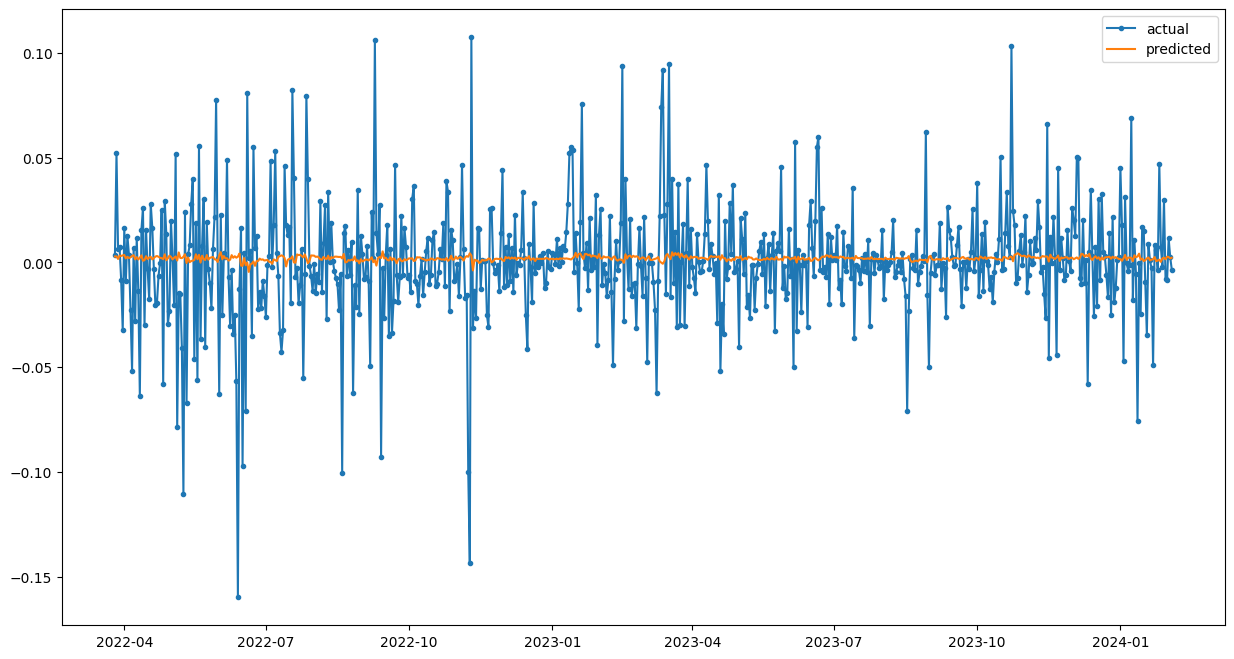

In [17]:
plt.figure(figsize=(15, 8))

plt.plot(test["Date"], test["Change"], label="actual", marker=".")
plt.plot(test["Date"], predictions, label="predicted")
plt.legend()


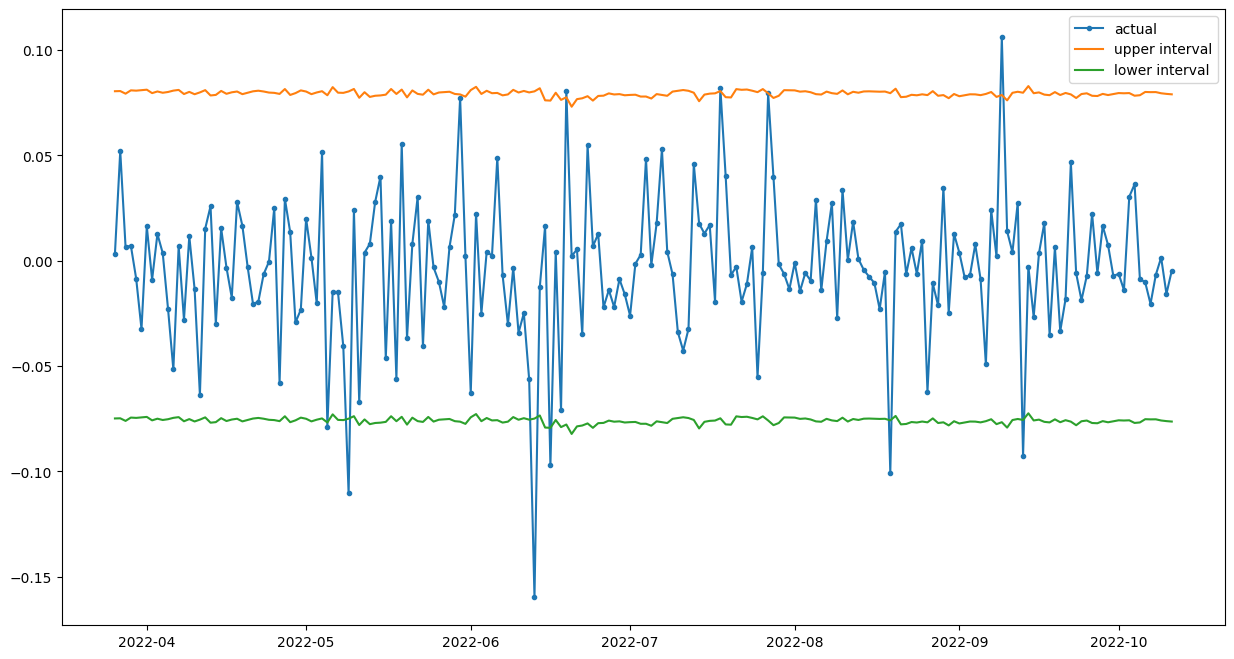

In [19]:
plt.figure(figsize=(15, 8))

plt.plot(test["Date"], test["Change"], label="actual", marker=".")
plt.plot(test["Date"], predictions + 2*std, label="upper interval")
plt.plot(test["Date"], predictions - 2*std, label="lower interval")
plt.legend()


LLM

In [ ]:
from dotenv import load_dotenv
from langchain import HuggingFaceHub
from langchain import PromptTemplate
from langchain.chains import LLMChain

load_dotenv()

True

In [ ]:
conv_model = HuggingFaceHub(repo_id='tiiuae/falcon-7b-instruct', model_kwargs={"max_new_tokens": 5000})

c:\Users\teani\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
template = '''You are an AI assistant that writes emails to inform users about the current price of BTC and it's expected change.
So if the expected change is in minus, users should be informed to invest. The opposite, the users should be 
informed to withdraw money. 

{query}
'''

prompt = PromptTemplate(template = template, input_variables=['query'])

In [ ]:
conv_chain = LLMChain(llm = conv_model, 
                      prompt = prompt,
                      verbose = True)

In [ ]:
btc_price = df['Close'].iloc[0]
change = predictions[-1]
message = conv_chain.run(f'Bitcoin price - {btc_price}, expected change - {change}%')

print(conv_chain.run(f'Bitcoin price - {btc_price}, expected change - {change}%'))

c:\Users\teani\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new LLMChain chain...
Prompt after formatting:
You are an AI assistant that writes emails to inform users about the current price of BTC and it's expected change.
So if the expected change is in minus, users should be informed to invest. The opposite, the users should be 
informed to withdraw money. 

Bitcoin price - 43224.38, expected change - 0.00163533082225475%


> Finished chain.


> Entering new LLMChain chain...
Prompt after formatting:
You are an AI assistant that writes emails to inform users about the current price of BTC and it's expected change.
So if the expected change is in minus, users should be informed to invest. The opposite, the users should be 
informed to withdraw money. 

Bitcoin price - 43224.38, expected change - 0.00163533082225475%


> Finished chain.
You are an AI assistant that writes emails to inform users about the current price of BTC and it's expected change.
So if the expected change is in minus, users should be informed to invest. The opp

In [ ]:
start_index = message.find("We hope this email")
# Extract the substring starting from the response

extracted_response = message[start_index:]
print(extracted_response)

We hope this email finds you well. We wanted to inform you about the current price of Bitcoin, which is currently trading at $43224.38. Our experts predict a 0.00163533082225475% change in the price in the upcoming hours.

We recommend that investors keep a close eye on the market and consider withdrawing their funds if the price is in a negative trend. Conversely, if the price is expected to rise, investors


EMAIL

In [ ]:
import smtplib

sender = 'btcnotification036@gmail.com'
recivers = ['tea.nikolic525@gmail.com']
message = f"""From: BTC Notification from Gmail <btcnotification036@gmail.com>
To: Teodora Nikolic {recivers[0]}
Subject: Bitcoin notification

{extracted_response}


"""


smtpObj = smtplib.SMTP('smtp.gmail.com', 587)
smtpObj.starttls() 
smtpObj.login(sender,'whdp xlyo zfux poxh')  

smtpObj.sendmail(sender, recivers, message)        
print("Successfully sent email")

Successfully sent email
